# Exercise 2: Simulating heat diffusion on the GPU

1. Something
2. Something else

In [1]:
print("hello world")

hello world


In [2]:
import pycuda

In [4]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Heat equation

We are going to solve the heat equation, which is
$
\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}
$

We need to do the following: 
* Create variables u0 and u1. u0 are the "old" temperatures, u1 are the new temperatures.
* Initialize the original temperature
* In a for-loop, solve the heat equation one timestep at a time
* Plot after x timesteps

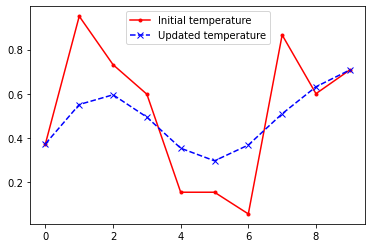

In [23]:
def heatEquation(u0, num_timesteps, kappa, dt, dx):
    #We have u0 - initial temperatures. Need to make space for u1
    u1 = np.empty_like(u0)
    
    #Find out how many cells there are in u0 (how many numbers?)
    num_cells = u0.shape[0]
    
    #We use n as the time index, and i as the space-index
    #First a for-loop for the time dimension
    for n in range(num_timesteps):
        #Compute u1 from u0
        # A for-loop for the space-dimension
        #Loop over all "internal" cells. 
        for i in range(1, num_cells-1):
            u1[i] = u0[i] + kappa*dt/(dx*dx) * (u0[i-1] - 2*u0[i] + u0[i+1])
            
        #Set boundary conditions
        u1[0] = u0[0]
        u1[num_cells-1] = u0[num_cells-1]
        
        #Swap the new and old temperatures
        u0, u1 = u1, u0
    
    #Return the updated temperatures
    return u0
    
np.random.seed(42)
initial_temp = np.random.rand(10)
u1 = heatEquation(u0=initial_temp.copy(), kappa=1, dt=0.25, dx=1, num_timesteps=4)

plt.plot(initial_temp, 'r.-', label="Initial temperature")
plt.plot(u1, 'bx--', label="Updated temperature")
plt.legend()

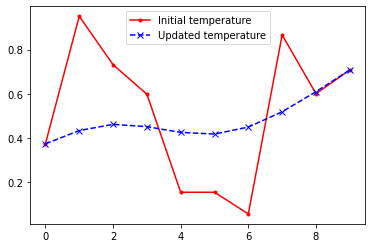

In [47]:
heat_eqn_kernel_src = """
__global__ void heatEqn1D(
            float* u1, 
            float* u0,
            float kappa, 
            float dx,
            float dt,
            unsigned int nx) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    
    //First cell: boundary
    if (i == 0) {
        u1[i] = u0[i];
    }
    //Last cell: boundary
    else if (i == nx-1) {
        u1[i] = u0[i];
    }
    //Internal cells
    else if (i < nx-1) {
        u1[i] = u0[i] + kappa*dt/(dx*dx) * (u0[i-1] - 2*u0[i] + u0[i+1]);
    }
}
"""

mod = SourceModule(heat_eqn_kernel_src)
heatEqnGPU = mod.get_function("heatEqn1D")


def heatEquationGPU(u0, num_timesteps, kappa, dt, dx):
    #We're using single precision in our kernel
    assert(u0.dtype == np.float32)
    
    #We have u0 - initial temperatures. Need to make space for u1
    #Move to GPU!!!
    u1_gpu = cuda.mem_alloc(u0.nbytes)
    
    #Also make u0 on the GPU and upload from CPU
    u0_gpu = cuda.mem_alloc(u0.nbytes)
    cuda.memcpy_htod(u0_gpu, u0)
    
    #Find out how many cells there are in u0 (how many numbers?)
    num_cells = u0.shape[0]
    
    #Compute block and grid size:
    block=(512,1,1)
    grid=(int(np.ceil(num_cells/512)),1,1)
    
    #We use n as the time index, and i as the space-index
    #First a for-loop for the time dimension
    for n in range(num_timesteps):
        #Compute u1 from u0
        # A for-loop for the space-dimension
        #Loop over all "internal" cells. 
        #Move to GPU!!!
        #Kernel function arguments:  float* u1, 
        #float* u0,
        #float kappa, 
        #float dx,
        #float dt,
        #unsigned int nx
        heatEqnGPU(u1_gpu, u0_gpu, np.float32(kappa), np.float32(dx), np.float32(dt), np.uint32(num_cells), block=block, grid=grid)
        
        #Swap the new and old temperatures
        u0_gpu, u1_gpu = u1_gpu, u0_gpu
    
    #Download u0 - new temperatures from the GPU to the CPU. 
    u1 = np.empty_like(u0)
    cuda.memcpy_dtoh(u1, u0_gpu)
    
    #Return the updated temperatures
    return u1
    
np.random.seed(42)
initial_temp = np.random.rand(10).astype(np.float32)
u1 = heatEquationGPU(u0=initial_temp.copy(), kappa=1, dt=0.25, dx=1, num_timesteps=10)

plt.plot(initial_temp, 'r.-', label="Initial temperature")
plt.plot(u1, 'bx--', label="Updated temperature")
plt.legend()